# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Doga Tekin",
        'student_2': "Serif Soner Serbest"}

sciper = {'student_1': 293688, 
          'student_2': 294910}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import pickle

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations = getRawDataFromFile()

list(np.random.choice(conversations, size=2, replace=False))

[['good evening . how are you doing ?',
  'i am good . had some really good super hot wings tonight . you ?',
  'sounds good ! and i am just peachy . enjoying scary movies tonight .',
  'scary movies are awesome ! i watched so many when i worked at the theater',
  'that would be a cool job . although i would like to be a designer some day .',
  'that sounds cool . i want to photograph fashion someday with my new camera',
  'do it . no dream is too big . i just moved to ny to pursue mine .',
  'awesome ! do you think i should cut my long hair to make a fresh start ?',
  'bold move . but you sound like you could use a fresh start .',
  'yes ! i have been running nightly to try to get in shape',
  'good luck ! i love to go shopping . that is my exercise .',
  'sounds like a fun way to exercise',
  'it is . also an expensive one . but fashion is my thing . so it is okay ,',
  'you sound like a super cool person !'],
 ['hello . how are you ?',
  'i am good . i have been working in my garden

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** *Zipf's law states that the frequenct of any word is inversely proportional to its rank in a corpus which can be observed as a line in log-log scale. We observed a almost linearly plot which conforms to Zipf's Law.*  

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** *7080*



In [4]:
from collections import Counter

In [5]:
sentences = [sentence for conversation in conversations for sentence in conversation]

words = ' '.join(sentences)
dictionary = Counter(words.split(' '))

Text(0, 0.5, 'count')

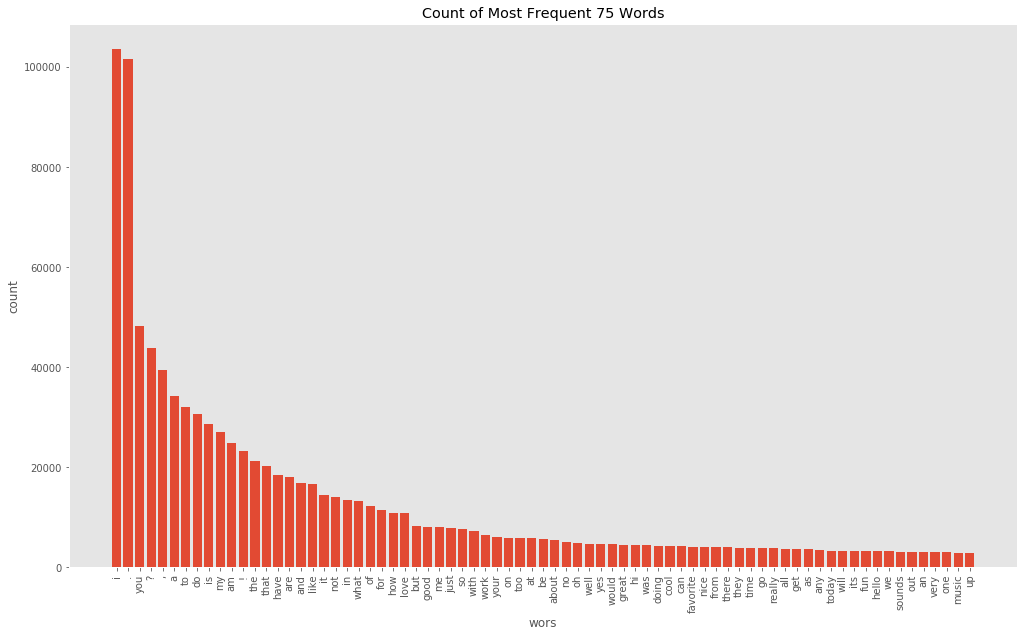

In [6]:
frequent_words, count = zip(*dictionary.most_common(75))

plt.figure(figsize=(17, 10))
plt.bar(frequent_words, count)
plt.xticks(rotation='vertical')
plt.title("Count of Most Frequent 75 Words")
plt.xlabel("wors")
plt.ylabel("count")

Text(0, 0.5, 'count')

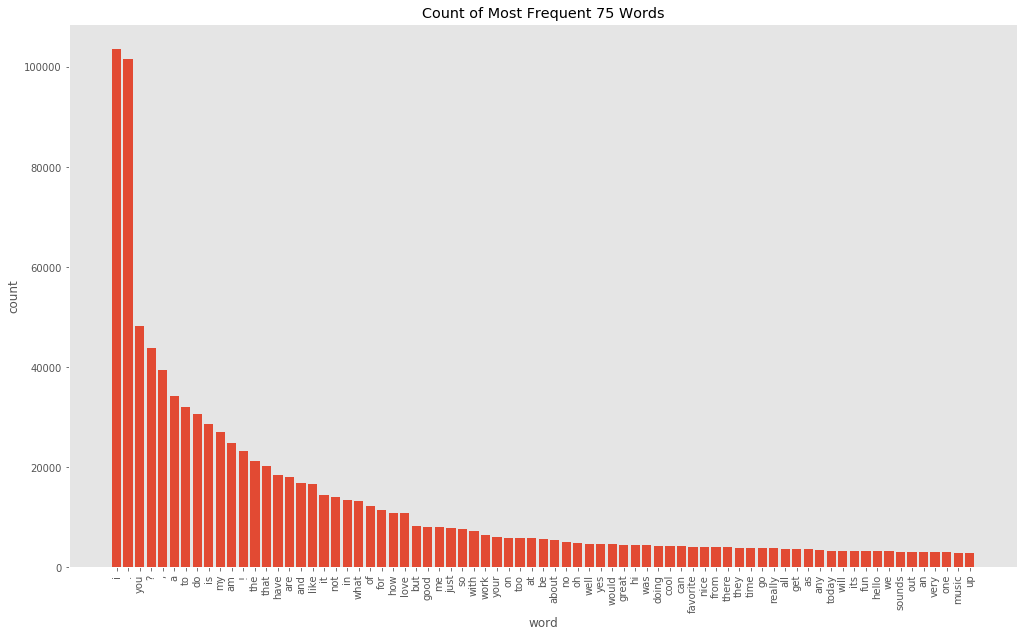

In [7]:
frequent_words, count = zip(*dictionary.most_common(75))

plt.figure(figsize=(17, 10))
plt.bar(frequent_words, count)
plt.xticks(rotation='vertical')
plt.title("Count of Most Frequent 75 Words")
plt.xlabel("word")
plt.ylabel("count")

Text(0, 0.5, 'count')

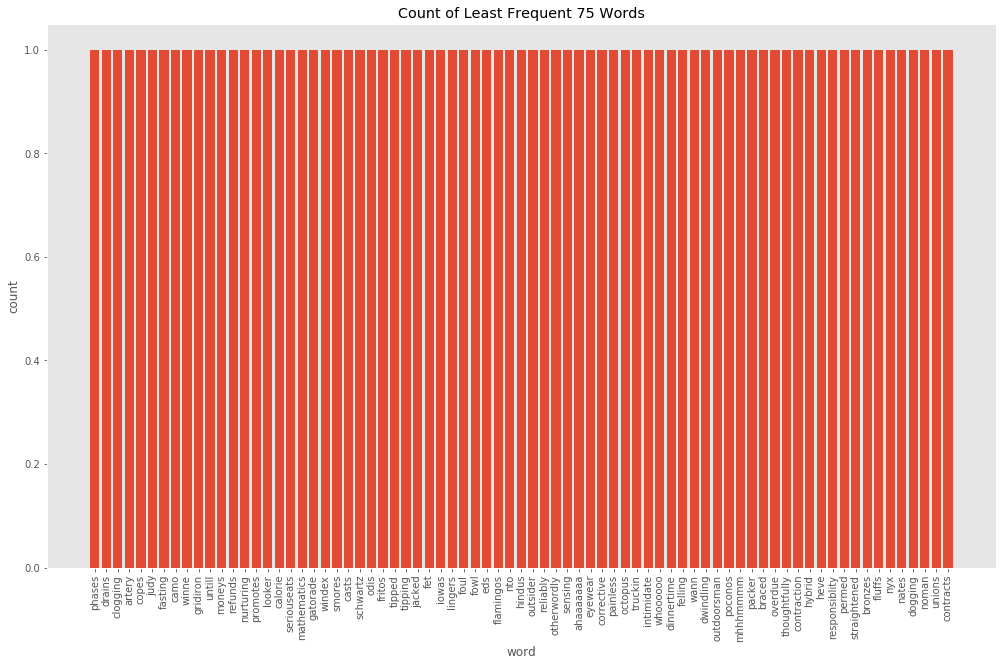

In [8]:
least_frequent_words, count = zip(*dictionary.most_common()[:-76:-1])

plt.figure(figsize=(17, 10))
plt.bar(least_frequent_words, count)
plt.xticks(rotation='vertical')
plt.title("Count of Least Frequent 75 Words")
plt.xlabel("word")
plt.ylabel("count")

Text(0, 0.5, 'count in log scale')

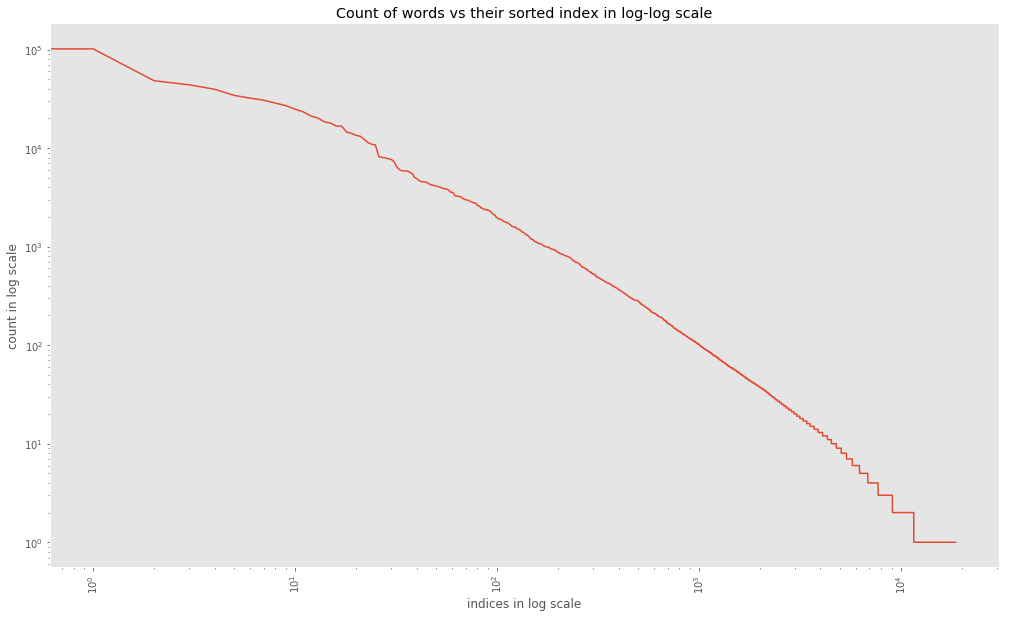

In [9]:
_, sorted_counts = zip(*dictionary.most_common())

plt.figure(figsize=(17, 10))
plt.loglog(sorted_counts)
plt.xticks(rotation='vertical')
plt.title("Count of words vs their sorted index in log-log scale")
plt.xlabel("indices in log scale")
plt.ylabel("count in log scale")

In [10]:
# number of words appear only once in the dataset
sum(np.array(sorted_counts) == 1)

7080

### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: *We aproximately reduce the unique_words with a rate of 1/12 which corresponds to 1644 words out of 18673*

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: *There are 131424 sentences in original dataset and 67024 sentences in filtered dataset*

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: *In terms of learning, it provides cleaner and smaller dataset that allows to train faster. In terms of generalization, it removes context specific terms and allows network to respond in a more common language.*

In [13]:
frequent_dictionary = {}
count_threshold = 50

for word in dictionary:
    if dictionary[word] >= count_threshold: frequent_dictionary[word] = dictionary[word]
        
len(frequent_dictionary), len(dictionary)

(1644, 18673)

In [14]:
filtered_sentences = []

for sentence in sentences:
    words = set(sentence.split(' '))
    include = True
    for word in words:
        if not word in frequent_dictionary: include = False
    if include: filtered_sentences.append(sentence)

In [15]:
len(filtered_sentences), len(sentences)

(67024, 131424)

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [16]:
# Create tokenization dictionary that links words with their tokens
word_to_token = {'PADD': 0, 'START': 1, 'END': 2}
token_to_word = {0: 'PADD', 1: 'START', 2: 'END'}

k = 3
for word in frequent_dictionary:
    word_to_token[word] = k
    token_to_word[k] = word
    k += 1

In [17]:
# transform dataset to tokenized dataset with 'START' and 'END' tokens

tokenized_sentences = []

for sentence in filtered_sentences:
    token = [word_to_token['START']]
    for word in sentence.split(' '):
        token.append(word_to_token[word])
    token.append(word_to_token['END'])
    tokenized_sentences.append(token)

Text(0.5, 1.0, 'Violinplot of Tokenized Sentences')

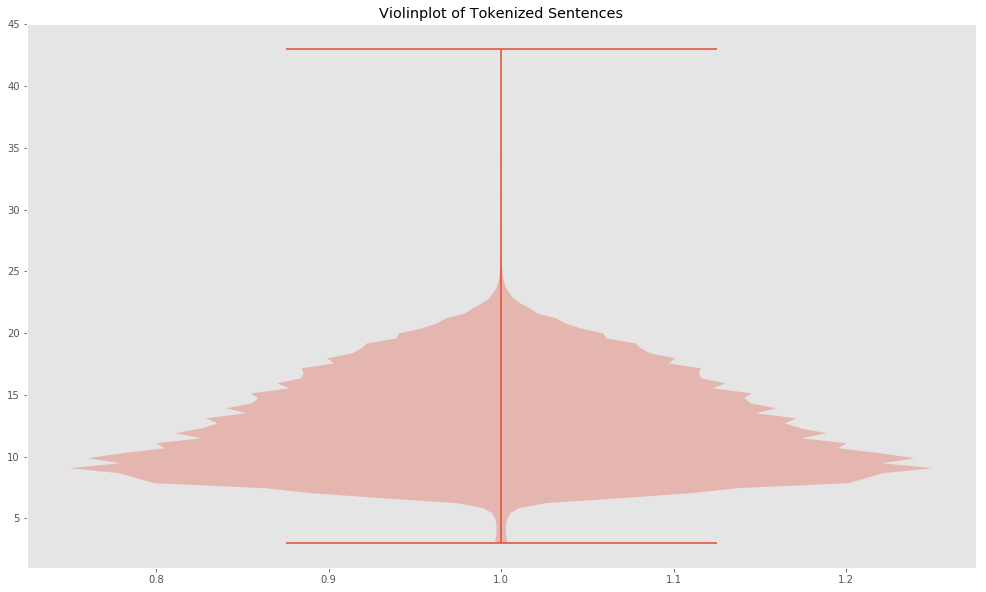

In [18]:
# plot violinplot
lengths_of_tokenized_sentences = [len(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

plt.figure(figsize=(17, 10))
plt.violinplot(lengths_of_tokenized_sentences)
plt.title("Violinplot of Tokenized Sentences")

In [19]:
# pad the dataset
maxlen = 25
padded_tokenized_sentences=pad_sequences(tokenized_sentences, maxlen=maxlen, padding='post', truncating='post', value=word_to_token['PADD'])

In [20]:
def tokenlisttosentence(tokenlist):
    sentence = ''
    for token in tokenlist[1:]:
        if token == word_to_token['END']: break
        else: sentence = sentence + token_to_word[token] + ' '
    return sentence[:-1]

In [21]:
idx = np.random.randint(len(padded_tokenized_sentences))
print("original: ", filtered_sentences[idx], "recovered: ", tokenlisttosentence(padded_tokenized_sentences[idx]))
idx = np.random.randint(len(padded_tokenized_sentences))
print("original: ", filtered_sentences[idx], "recovered: ", tokenlisttosentence(padded_tokenized_sentences[idx]))

original:  cool ! my name is mary . where are you from ? recovered:  cool ! my name is mary . where are you from ?
original:  i am with you on that what ways have you had fun ? recovered:  i am with you on that what ways have you had fun ?


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [ ]:
import pickle

#save
# with open("data.pkl", "wb") as file:
#     pickle.dump([filtered_sentences, dictionary, tokens], file)
    
# #load
# with open("data.pkl", "rb") as file:
#     [filtered_sentences, dictionary, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** We are masking 'PADD' tokens in embedding layer by activating mask_zero parameter. Hence, the network ignores PADDED timesteps and exclude them in trainning and error computations.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**:
This network gives word transition probability distribution of each time step by looking at all preceding words by learning from the actual word in that time step in the dataset.

Inputs are padded tokenized sentences with the last word removed, which is a 67024 x 24 tensor.
Targets are the one hot encoded tokens of sentences with the first word, removed which is 67024 x 24 x 1647 tensor.

For each batch
input = (batch_size, 24)
output = (batch_size, 24, 1647)

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: Although GRU and LSTM perform similarly, GRU has the best validation accuracy . GRU is the fastest learner as it is seen in comparison graph.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: We observe overfitting clearly in GRU and slightly in Simple RNN around 10-15 epoch. One possible explanation could be such that GRU and Simple RNN  learn faster than LSTM as it is seen in comparison graph so that they overfit faster since no precaution is undertaken for overfitting in these networks.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Increasing dataset size (# of sentences in the dataset)

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Recurrent Dropout

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Early Stopping

In [22]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [23]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [24]:
from keras.utils import to_categorical

X = padded_tokenized_sentences
T = to_categorical(X)
maxlen=X.shape[1]
tokens = list(token_to_word.keys())

In [25]:
X.shape, T.shape

((67024, 25), (67024, 25, 1647))

In [106]:
def createModels():
    modelnames = ['RNN', 'GRU', 'LSTM']
    
    for modelname in modelnames:
        print(modelname)
        I[modelname] = Input(shape=(maxlen-1,), name="input")
        E[modelname] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")
        if modelname == 'RNN':
            H[modelname] = SimpleRNN(units=hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E[modelname](I[modelname]))  #... Recurrent layer(s)
        elif modelname == 'GRU':
            H[modelname] = GRU(units=hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E[modelname](I[modelname]))  #... Recurrent layer(s)
        elif modelname == 'LSTM':
            H[modelname] = LSTM(units=hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E[modelname](I[modelname]))  #... Recurrent layer(s)
        else:
            print('something went wrong ...')
        R[modelname] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[modelname])  #... Readout
        Y[modelname] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R[modelname])  #... Output
        
        models[modelname] = Model(inputs = [I[modelname]], outputs = [Y[modelname]])
        models[modelname].compile(
            loss='categorical_crossentropy', 
            optimizer=Adam(),
            metrics=['acc'])
        models[modelname].summary()

createModels()

RNN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           210816    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1647)          212463    
Total params: 443,951
Trainable params: 443,951
Non-trainable params: 0
_________________________________________________________________
GRU
_________________________________________________________________
Layer (type)                 Output Shape              Param #

In [36]:
def trainModel(modelname):
    logs[modelname] = models[modelname].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size).history
    #save
    with open(str(modelname)+"model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
        pickle.dump(logs[modelname], file)
    models[modelname].save( str(modelname)+"model_"+str(embedding_size)+'_'+str(hidden_size))
    
#trainModel('RNN')
#trainModel('GRU')
#trainModel('LSTM')

In [121]:
#load models
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    LSTMmodel_log = pickle.load(file)
LSTMmodel = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

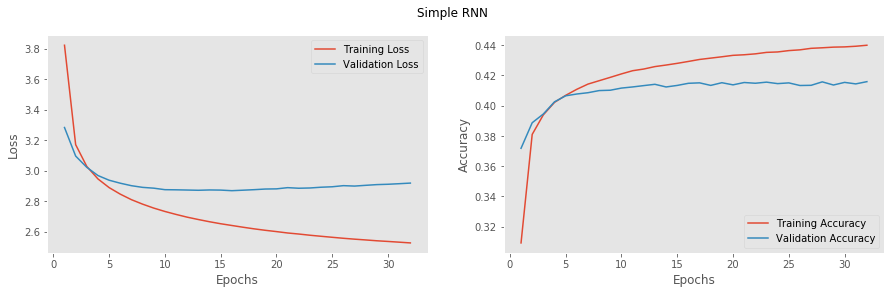

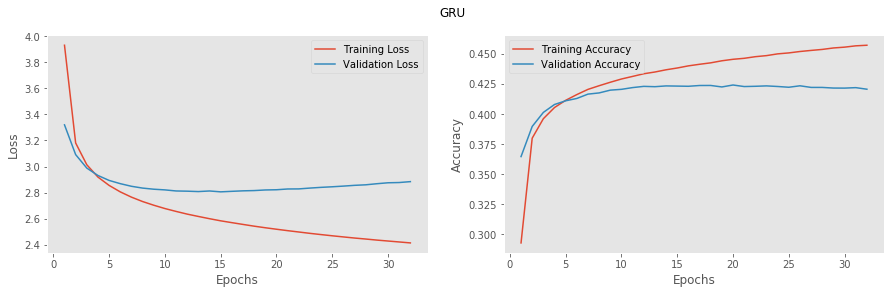

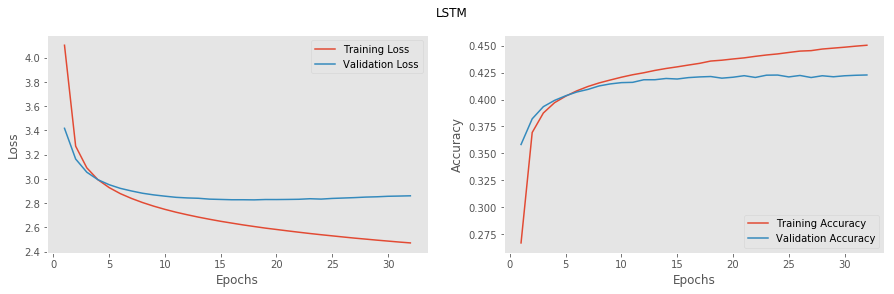

In [305]:
# plot loss and accuracy curves and compare models
def plot_curves(model_log, title=''):
    t = range(1, len(model_log['loss'])+1)

    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].plot(t, model_log['loss'], label='Training Loss')
    axs[0].plot(t, model_log['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(t, model_log['acc'], label='Training Accuracy')
    axs[1].plot(t, model_log['val_acc'], label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.suptitle(title);
    
def compare(logs, names):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    
    for log, name in zip(logs, names):
        axs[0].plot(log['val_loss'], label=name)
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        
        axs[1].plot(log['val_acc'], label=name)
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

plot_curves(RNNmodel_log, 'Simple RNN')
plot_curves(GRUmodel_log, 'GRU')
plot_curves(LSTMmodel_log, 'LSTM')

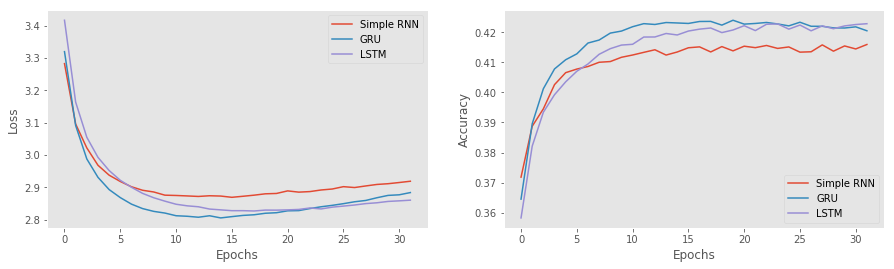

In [306]:
compare(logs=[RNNmodel_log, GRUmodel_log, LSTMmodel_log], names=['Simple RNN', 'GRU', 'LSTM'])

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** GRU with 256 hidden units converged the fastest and achieved the highest performance. The two layer model was slower to converge because it had more layers. GRU with 128 units performed similarly but slightly worse than 256 in terms of validation accuracy and convergence speed.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** It had the effect of stopping training on all our networks around 10 epochs. One advantage is that it stops training when the network starts to overfit, so we end up with a more generalizable network. One drawback is that it's hard to detect when the network actually starts to overfit, so it might end up stopping too early before the network converges.

**Question** What is your best model? Why? [1 pt]

**Answer** GRU 256 is our best model because it has the highest validation accuracy and convergence speed. This is because it has more representation power since it has more units than the 128 unit one and it is faster because it has only one layer instead of two like the other model.

In [25]:
trained_embedding_weights = GRUmodel.get_weights()[0]
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

In [70]:
def createGRUModels():
    modelnames = ['GRU128', 'GRU256', 'GRU64']
    
    for modelname in modelnames:
        print(modelname)
        I[modelname] = Input(shape=(maxlen-1,), name="input")
        E[modelname] = Embedding(len(tokens), embedding_size, weights=[trained_embedding_weights], mask_zero=True, name="embedding")
        if modelname == 'GRU128':
            H['GRU128'] = GRU(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E['GRU128'](I['GRU128']))  #... Recurrent layer(s)
        elif modelname == 'GRU256':
            H['GRU256'] = GRU(units=256, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E['GRU256'](I['GRU256']))  #... Recurrent layer(s)
        elif modelname == 'GRU64':
            GRU_first_layer = GRU(units=64, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E['GRU64'](I['GRU64']))  #... Recurrent layer(s)
            H['GRU64'] = GRU(units=64, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(GRU_first_layer)  #... Recurrent layer(s)

        else:
            print('something went wrong ...')
        R[modelname] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[modelname])  #... Readout
        Y[modelname] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R[modelname])  #... Output
        
        models[modelname] = Model(inputs = [I[modelname]], outputs = [Y[modelname]])
        models[modelname].compile(
            loss='categorical_crossentropy', 
            optimizer=Adam(),
            metrics=['acc'])
        models[modelname].summary()

createGRUModels()

GRU128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           210816    
_________________________________________________________________
gru_15 (GRU)                 (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1647)          212463    
Total params: 538,479
Trainable params: 538,479
Non-trainable params: 0
_________________________________________________________________
GRU256
_________________________________________________________________
Layer (type)                 Output Shape              P

In [25]:
def trainModelWithEarlystopping(modelname, early_stopping):
    logs[modelname] = models[modelname].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size,
                                        callbacks=[early_stopping]).history
    #save
    with open(str(modelname)+"model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
        pickle.dump(logs[modelname], file)
    models[modelname].save( str(modelname)+"model_"+str(embedding_size)+'_'+str(hidden_size))

#trainModelWithEarlystopping('GRU128', early_stopping)
#trainModelWithEarlystopping('GRU256', early_stopping)
#trainModelWithEarlystopping('GRU64', early_stopping)

In [118]:
#load models
with open("GRU128model_"+str(embedding_size)+'_'+str(128)+"_log.pkl", "rb") as file:
    GRU128model_log = pickle.load(file)
GRU128model = load_model("GRU128model_"+str(embedding_size)+'_'+str(128))

with open("GRU256model_"+str(embedding_size)+'_'+str(64)+"_log.pkl", "rb") as file:
    GRU256model_log = pickle.load(file)
GRU256model = load_model("GRU256model_"+str(embedding_size)+'_'+str(64))

with open("GRU64model_"+str(embedding_size)+'_'+str(64)+"_log.pkl", "rb") as file:
    GRU64model_log = pickle.load(file)
GU64model = load_model("GRU64model_"+str(embedding_size)+'_'+str(64))

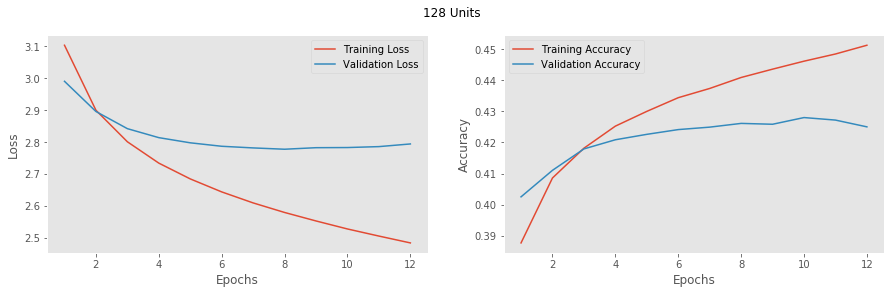

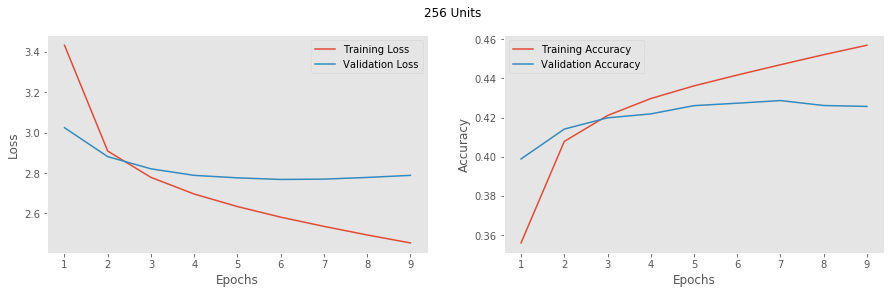

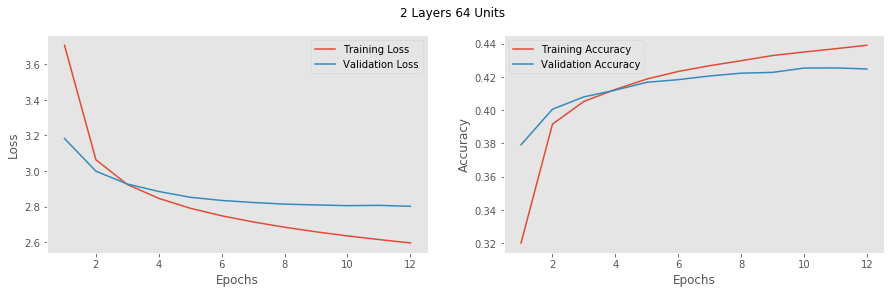

In [123]:
plot_curves(GRU128model_log, '128 Units')
plot_curves(GRU256model_log, '256 Units')
plot_curves(GRU64model_log, '2 Layers 64 Units')

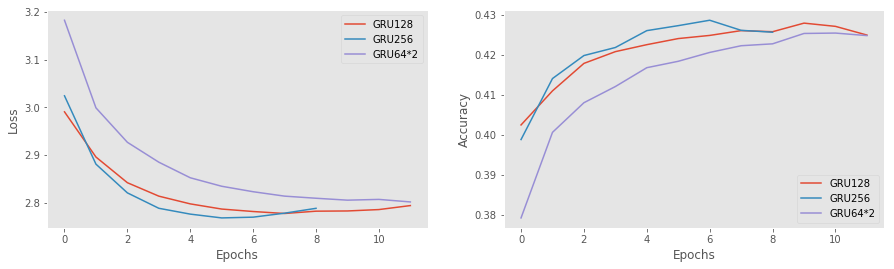

In [307]:
compare(logs=[GRU128model_log, GRU256model_log, GRU64model_log],names=['GRU128', 'GRU256', 'GRU64*2'])

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Temperature controls the randomness of predictions. On smaller values, network is more confident and conservative to sample from unlikely candidates. On larger values, network is more creative by selecting diverse words and also it makes more mistakes.



**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** As temperature goes to 0, the probability of the word with the highest output in the layer tends to 1 while others tends to zero.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1 corresponds to? [1 pt] 

**Answer** When the temperature is 1, we compute the softmax directly on the unscaled outputs of output layer.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** As sampling temperature increases result of softmax gets closer to the uniform distribution because of the scaled exponential function. 

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** According to input sentence, network gives word transition probability distribution of each time step by looking at all preceding words. By iterating over each time step, and adding the randomly selected word from the distribution to the sentence, complete sentence is generated at the end of the iteration (or by obtaining 'END' token).

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes. Indeed networks models the nature of the language nicely since there are many possible words to continue a sentence at any given moment.

In [281]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    # assign very low probability to zeros to not get divide by zero error 
    ######################################################################
    preds[preds == 0] = 1e-100
    ######################################################################
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate(model, temperature = 1., print_sentence = True):
    token_list = np.zeros((1, maxlen - 1)).astype('int32')
    next_token = 1 # 'START'
    token_list[0,0] = next_token
    i = 1
    while not next_token == word_to_token['END'] and not i == maxlen - 1:
        preds = model.predict(token_list)
        next_token = sample(preds.squeeze()[i - 1, :], temperature)
        token_list[0, i] = next_token
        if i == 1: pred_list = preds.squeeze()[i - 1, :]
        else: pred_list = np.vstack((pred_list, preds.squeeze()[i - 1, :]))
        i += 1
        
    
    sentence = tokenlisttosentence(token_list.squeeze())
    #print("token list:", token_list)
    if print_sentence: print("sentence:", sentence)
    
    return token_list, sentence, pred_list

In [308]:
# generate 10 sentences for each temperature
for temperature in  [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]:
    print('temperature:', temperature)
    for i in range(10):
        generate(GRU256model, temperature)
    print('---')

temperature: 0.0
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
sentence: i am a teacher , i am a college student
---
temperature: 0.25
sentence: i do not have any pets
sentence: that is cool . i am a waitress at a local restaurant .
sentence: i am doing good . how are you ?
sentence: i am good . just got back from a run .
sentence: i am good . just got back from a long walk with my dog .
sentence: i am doing well , how are you ?
sentence: i have a cat , he is a cop .
sentence: i am good . just got back from a run .
sentence: i am doing well , how are you ?
sentence: i am a student , i am a

temperature: 0.0
sentence: i am a teacher , i am a college student
temperature: 0.25
sentence: i am good . just got back from a run .
temperature: 0.5
sentence: i am a baker , what about you ?
temperature: 0.75
sentence: you are busy ! it is just a lot of work .
temperature: 1.0
sentence: i have traveled and play before . do you work with your family at national parks ?
temperature: 1.5
sentence: 14 hours i hope a huge goal in before , thanks any vacation !
temperature: 2.0
sentence: eh big good team coach your highschool just get nice going out


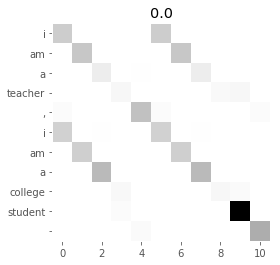

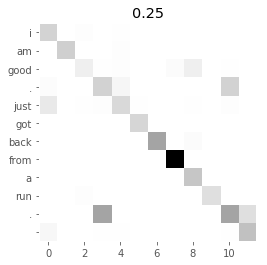

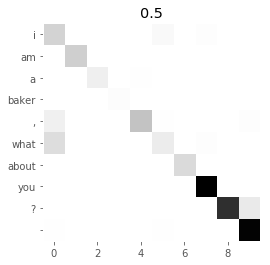

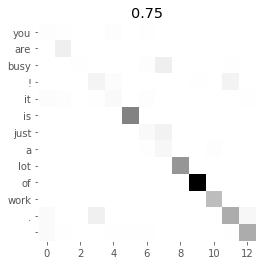

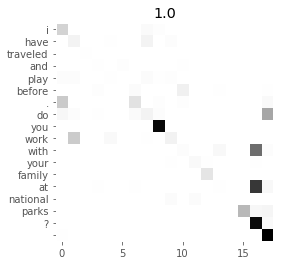

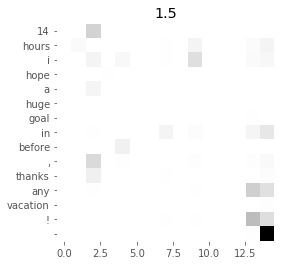

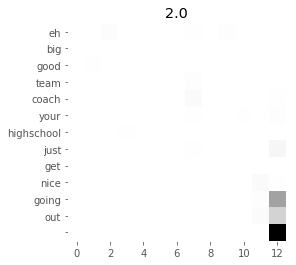

In [313]:
# generate heatmap for sentences for each temperature

temperatures = [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]
for i, temperature in enumerate(temperatures):
    print('temperature:', temperature)
    tl, s, pl = generate(GRU256model, temperature)
    word_num = len(s.split()) + 1
    x = pl[:,tl[:,1:word_num + 1]]
    
    plt.figure()
    plt.imshow(x.squeeze(), cmap='Greys')
    #plt.gca().invert_xaxis()
    plt.yticks(np.arange(word_num), s.split());
    plt.title(temperature)

In [145]:
# generate two beginings with temperature 0.75
'''selected two nice beginning by running the cells several times'''
tl1, s1, pl1 = generate(GRU256model, 0.75)
tl2, s2, pl2 = generate(GRU256model, 0.75)

token_list_1 = tl1[:,:5]
token_list_2 = tl2[:,:5]

sentence1 = ' '.join(s1.split()[:4])
sentence2 = ' '.join(s2.split()[:4])

sentence1, sentence2

sentence: i am doing good , thanks for asking .
sentence: that would be a good idea . i do not have pets either


('i am doing good', 'that would be a')

In [146]:
# complete the missing sentences decided above
def complete(model, tokens):
    _, i = tokens.shape
    next_token = tokens[:,-1]
    token_list = np.hstack((tokens, np.zeros((1,24 - i))))
    while not next_token == word_to_token['END'] and not i == maxlen - 1:
        preds = model.predict(token_list)
        next_token = sample(preds.squeeze()[i - 1, :], temperature=1)
        token_list[0, i] = next_token
        i += 1

    sentence = tokenlisttosentence(token_list.squeeze())
    #print("token list:", token_list)
    print("sentence:", sentence)

print('input:',sentence1)
for i in range(10):
    complete(GRU256model, token_list_1)
print('---')
print('input:',sentence2)
for i in range(10):
    complete(GRU256model, token_list_2)

input: i am doing good
sentence: i am doing good and yourself ?
sentence: i am doing good eating down for dinner ?
sentence: i am doing good just playing soccer , not really a lot of chinese food , what do you do for a living
sentence: i am doing good . not at all
sentence: i am doing good thanks for asking
sentence: i am doing good . what about you ?
sentence: i am doing good just reading a book
sentence: i am doing good too . just relaxing . what are you up to today ?
sentence: i am doing good . just came in from my job .
sentence: i am doing good , do you like the color pink ?
---
input: that would be a
sentence: that would be a cool name . do you have any hobbies ?
sentence: that would be a good way to be more soon
sentence: that would be a awesome league .
sentence: that would be a good idea . she plays sports . and you ?
sentence: that would be a annoying do i think i fell .
sentence: that would be a weird body . i have 5 kids
sentence: that would be a amazing cook . want to teac

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** Yes, for example: (do, did, does), (will, would, can, could, should, must), (is, was, are).

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** Neural network fed by similar vector representations outputs similar probability distributions for similar words. This enables network to represent distributions of word more correctly in terms of grammar and semantics with limited number of parameters since clusters of words carry grammatical end semantic information with themselves. E.g. (cats, dogs, animals) are both plural objects and carry similar semantics which can be replacable in a sentence. In terms of generalization, having the knowledge that two words are similar allows the network to generate sentences that it did not see in the training dataset by exploiting these similarities. E.g. with the (do, did, does) cluster above, the network can generate a sentence like "He did ..." even though it only saw sentences like "He does" in the training data.



In [28]:
from sklearn.manifold import TSNE

In [72]:
top_200 = list(zip(*dictionary.most_common(200)))[0]
top_200_tokens = [word_to_token[word] for word in top_200]
X = to_categorical(top_200_tokens, num_classes=1647)

In [73]:
embedding_matrix = GRUmodel.get_weights()[0]

In [79]:
embedded = X @ embedding_matrix
projected = TSNE(n_components=2).fit_transform(embedded)

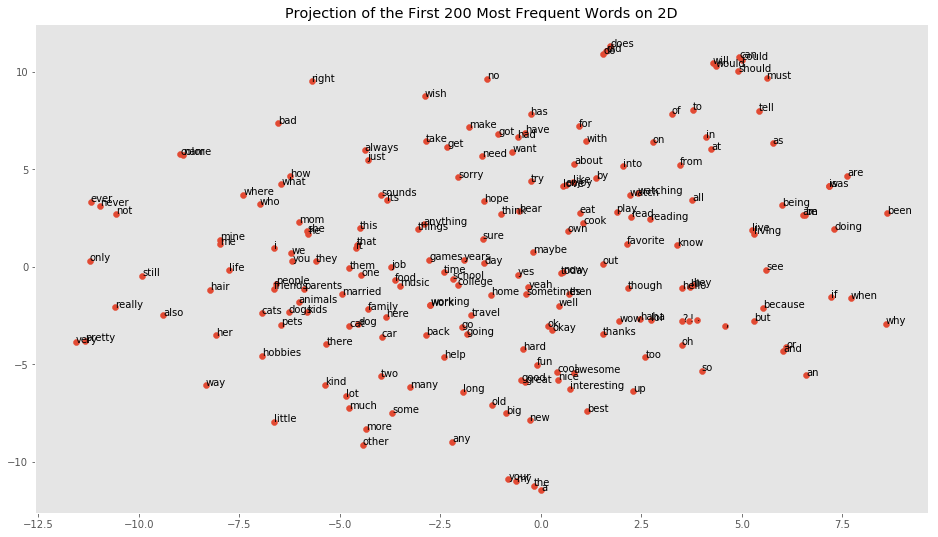

In [314]:
plt.figure(figsize=(16, 9))
plt.title('Projection of the First 200 Most Frequent Words on 2D')
plt.scatter(projected[:,0], projected[:,1])
for i, word in enumerate(top_200):
    plt.annotate(word, (projected[i,0], projected[i,1]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** Generally temperature 0.5 gives more similar answers than temperature 1.0. The answers are very similar for certain questions and very different for others.

Good example:
Context: hello , how are you doing ?
Real answer: hi , i am good how about you ?
Chatbot 0.5: i am good . how are you ?

Bad example:
Context: my least favorite food is tacos . but i absolutely love chocolate milk
Real answer: oh no where is your hair ? have any animals ?
Chatbot 0.5: i like to be a girl , but i love the cold weather

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** 0.5 gives better answers because it is less likely to choose unlikely words that don't make sense, which happens often with temperature 1.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, since it would not be generalizable and basically act as a memorized table instead of a chatbot.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]


Generate dataset:

In [98]:
contexts = []
answers = []

for conversation in conversations:
    for i in range(len(conversation)-1):
        context = conversation[i]
        answer = conversation[i+1]
        
        pair = context + ' ' + answer
        
        words = set(pair.split(' '))
   
        include = True
        for word in words:
            if not word in frequent_dictionary: 
                include = False

        if include: 
            contexts.append(context)
            answers.append(answer)

In [100]:
def tokenize_sentences(filtered_sentences, is_answer):
    # transform dataset to tokenized dataset with 'START' and 'END' tokens
    tokenized_sentences = []

    for sentence in filtered_sentences:
        if is_answer:
            token = [word_to_token['START']]
        else:
            token = []
        for word in sentence.split(' '):
            token.append(word_to_token[word])
        if is_answer:
            token.append(word_to_token['END'])
            
        tokenized_sentences.append(token)
        
    # plot violinplot
    lengths_of_tokenized_sentences = [len(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

    plt.figure(figsize=(17, 10))
    plt.violinplot(lengths_of_tokenized_sentences)
    plt.title("Violinplot of Tokenized Sentences")
    
    return tokenized_sentences

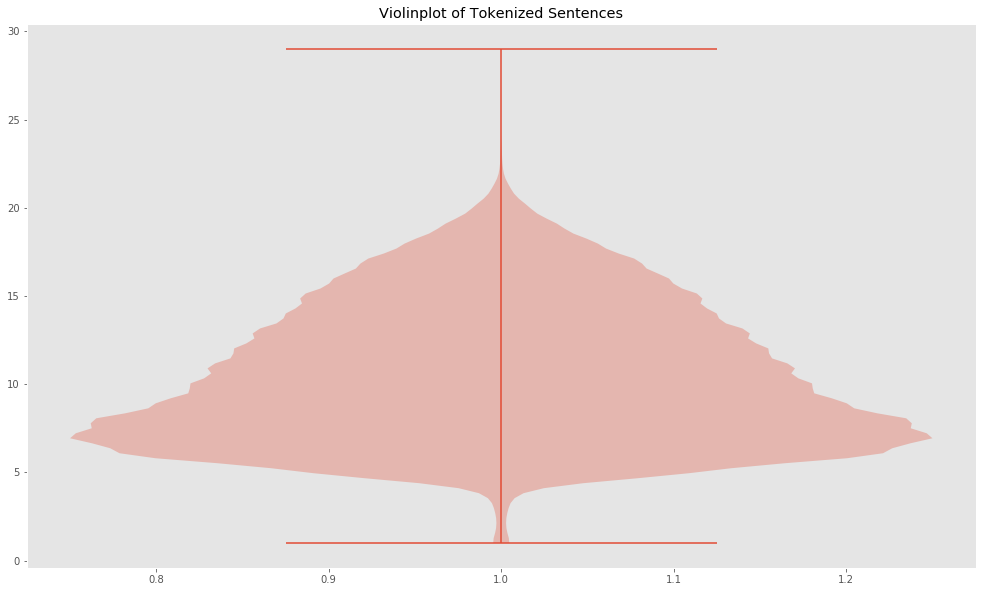

In [101]:
tokenized_contexts = tokenize_sentences(contexts, is_answer=False)

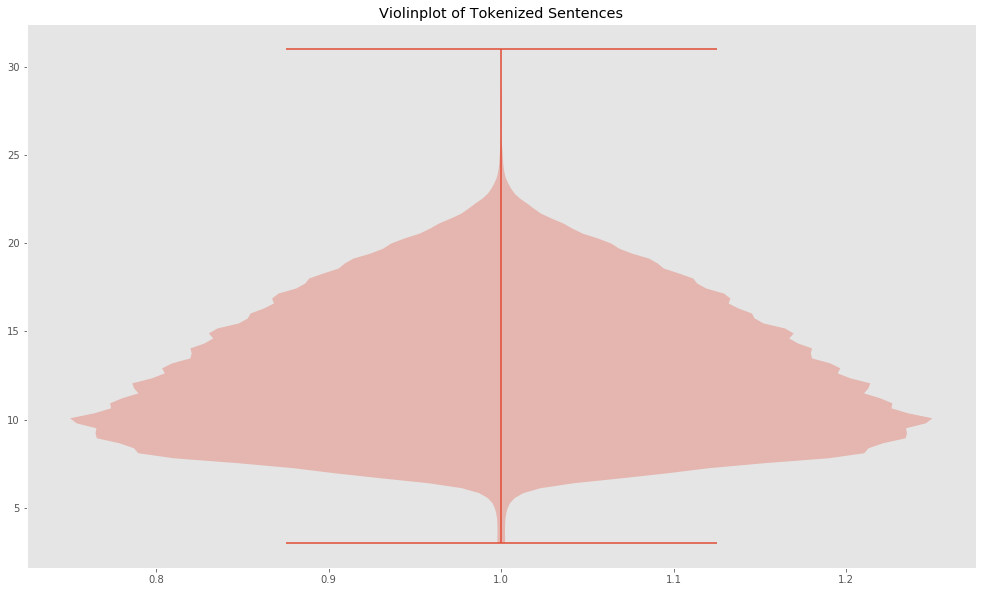

In [102]:
tokenized_answers = tokenize_sentences(answers, is_answer=True)

In [103]:
# pad the dataset
maxlen = 25
padded_tokenized_contexts = pad_sequences(tokenized_contexts, maxlen=maxlen-2, padding='post', truncating='post', value=word_to_token['PADD'])
padded_tokenized_answers = pad_sequences(tokenized_answers, maxlen=maxlen, padding='post', truncating='post', value=word_to_token['PADD'])

In [104]:
answers_input = padded_tokenized_answers[:,:-1]
answers_output = to_categorical(padded_tokenized_answers[:,1:])

In [112]:
E['GRU'] = GRUmodel.layers[1]

In [113]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 23)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             210816      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

In [114]:
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

chatbot_log = Chatbot.fit({'input_context': padded_tokenized_contexts,
                           'input_answer': answers_input}, 
                           {'output': answers_output}, 
                           epochs=epochs, 
                           validation_split=validation_split, 
                           batch_size=batch_size,
                           callbacks=[early_stopping]).history
#save
with open("chatbot_log.pkl", "wb") as file:
    pickle.dump(chatbot_log, file)
Chatbot.save("chatbot")

Train on 26652 samples, validate on 6663 samples
Epoch 1/32
26652/26652 [==============================] - 56s 2ms/step - loss: 4.2131 - acc: 0.2647 - val_loss: 3.5148 - val_acc: 0.3439
Epoch 2/32
26652/26652 [==============================] - 54s 2ms/step - loss: 3.3368 - acc: 0.3641 - val_loss: 3.2334 - val_acc: 0.3760
Epoch 3/32
26652/26652 [==============================] - 53s 2ms/step - loss: 3.1394 - acc: 0.3830 - val_loss: 3.1235 - val_acc: 0.3852
Epoch 4/32
26652/26652 [==============================] - 53s 2ms/step - loss: 3.0321 - acc: 0.3916 - val_loss: 3.0619 - val_acc: 0.3898
Epoch 5/32
26652/26652 [==============================] - 53s 2ms/step - loss: 2.9574 - acc: 0.3986 - val_loss: 3.0143 - val_acc: 0.3962
Epoch 6/32
26652/26652 [==============================] - 51s 2ms/step - loss: 2.8987 - acc: 0.4046 - val_loss: 2.9872 - val_acc: 0.3981
Epoch 7/32
26652/26652 [==============================] - 52s 2ms/step - loss: 2.8483 - acc: 0.4095 - val_loss: 2.9594 - val_acc:

/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Chatbot model cannot be loaded from the saved file properly due to a serializability issue regarding the initial state.

In [258]:
def generate_answer(model, context, temperature = 1.):
    tokenized_context = [word_to_token[word] for word in context.split(' ')]
    padded_context = pad_sequences([tokenized_context], maxlen=maxlen-2, padding='post', truncating='post', value=word_to_token['PADD'])
    
    token_list = np.zeros((1, maxlen - 1)).astype('int32')
    next_token = 1 # 'START'
    token_list[0,0] = next_token
    i = 1
    while not next_token == word_to_token['END'] and not i == maxlen - 1:
        preds = model.predict({'input_context': padded_context, 'input_answer': token_list})
        next_token = sample(preds.squeeze()[i - 1, :], temperature)
        token_list[0, i] = next_token
        if i == 1: pred_list = preds.squeeze()[i - 1, :]
        else: pred_list = np.vstack((pred_list, preds.squeeze()[i - 1, :]))
        i += 1
        
    answer = tokenlisttosentence(token_list.squeeze())
    
    return token_list, answer, pred_list

Comparison of real answers and the Chatbot answers for 10 randomly selected context sentences:

In [251]:
indices = np.random.choice(range(len(contexts)), size=10, replace=False)
random_contexts = np.array(contexts)[indices]
random_answers = np.array(answers)[indices]

In [260]:
for context, real_answer in zip(random_contexts, random_answers):
    _, answer_05, _ = generate_answer(Chatbot, context, temperature=0.5)
    _, answer_1, _ = generate_answer(Chatbot, context, temperature=1)
    print('Context:', context)    
    print('Real answer:', real_answer)    
    print('Chatbot 0.5:', answer_05)
    print('Chatbot 1.0:', answer_1)
    print('---')

Context: i am fine . i just got done in my garden . what are you doing ?
Real answer: just sewing i love to do that
Chatbot 0.5: i am good . how are you ?
Chatbot 1.0: hey ! i am getting a stay at home at the factory
---
Context: maybe i will travel to your farm ; i love seeing new places
Real answer: yes ! want to move to the city and get away from the farm
Chatbot 0.5: i love to sing but i am a teacher .
Chatbot 1.0: i understand , a concert may
---
Context: cool , college is where i go , i am a student
Real answer: me too , but i also have to work
Chatbot 0.5: what do you do for work ?
Chatbot 1.0: that sounds awesome ! i just have two cats to my clients
---
Context: my least favorite food is tacos . but i absolutely love chocolate milk
Real answer: oh no where is your hair ? have any animals ?
Chatbot 0.5: i like to be a girl , but i love the cold weather
Chatbot 1.0: a little blue , imagine dragons , thanks ! we concert to australia haha
---
Context: no i am an only child . i spen

Chat with the bot:

In [320]:
context = ''

while context != 'exit':
    context = input(prompt="You: ")
    
    words = context.split(' ')
    if not all(word in word_to_token.keys() for word in words):
        print("Bot: I don't understand you!")
    else:
        _, answer, _ = generate_answer(Chatbot, context, temperature=0.5)
        print("Bot:", answer)

You: hi .
Bot: hey ! tell me about yourself ?
You: i am a student . you tell me about yourself .
Bot: i am a student , i work at a lot . i love to read
You: how are you ?
Bot: i am doing great ! just got back from a run .
You: what do you like to do for fun ?
Bot: i like to play it , but i like to cook
You: nice to meet you .
Bot: i am a teacher , but i am hoping to go to the beach .
You: goodbye
Bot: I don't understand you!
You: bye
Bot: I don't understand you!
You: farewell
Bot: I don't understand you!
You: see you
Bot: i love the rolling stones music
You: me too !
Bot: i would like to be in the city
You: me too !
Bot: what do you like to do for fun ?
You: i like cooking .
Bot: i love going to it , i would love to drive it a lot .
You: exit
Bot: I don't understand you!


Bot chats with itself:

In [328]:
# generate a sentence from GRU256
_, context, _ = generate(GRU256model, temperature=0.1, print_sentence=False)

for i in range(5):
    print('Bot 1: ', context)
    _, answer, _ = generate_answer(Chatbot, context, temperature=0.5)
    print('Bot 2: ', answer)
    _, context,_ = generate_answer(Chatbot, answer, temperature=0.5)
    

Bot 1:  i am a student , and i am in school
Bot 2:  oh , that is cool . i love it .
Bot 1:  i like to watch netflix
Bot 2:  i love to travel much . do you like sports ?
Bot 1:  i have a dog . i live in the city .
Bot 2:  i love the beach too .
Bot 1:  what do you do for a living ?
Bot 2:  i am a teacher and i am a teacher
Bot 1:  well that is cool . i love animals . i have 2 kids .
Bot 2:  i love dogs , i am a little teacher .


---